# Unsupervised Learning for Wind Power Forecasting

This notebook implements the **Unsupervised Learning** part of *Assignment 1* (Course 46765 — Machine Learning for Energy Systems).  
The goal is to **improve wind power forecasting accuracy** by applying various **clustering techniques** to segment the dataset into different regimes and train **local regression models** per cluster.


## Notebook Overview

**General Idea:**  
Instead of one global regression model, we divide the dataset into subsets using unsupervised clustering (based on time, weather, or profile structure) and fit specialized models for each subset.  
We then compare the accuracy of all approaches.


### 1. Data Preparation
- Load and preprocess the dataset
- Drop irrelevant columns and scale numeric features
- Split into training and validation sets (chronological)

### 2. Baseline — Global Ridge Regression
- Train a single Ridge model
- Compute baseline RMSE, MAE, R²

### 3. Unsupervised Clustering Approaches
Each approach segments the data differently, then fits one Ridge model per cluster:

| # | Method | Description |
|:-:|:-------|:-------------|
| 1 | **K-Means (hourly)** | Clusters hourly data points into similar operating regimes |
| 2 | **Hierarchical Clustering** | Groups data without predefining *k* |
| 3 | **Temporal Hierarchical Clustering** | Adds adjacency constraint (consecutive hours only) |
| 4 | **Gaussian Mixture Model (GMM)** | Soft probabilistic clusters |
| 5 | **Daily-Profile Clustering** | Clusters entire days by their 24-hour patterns |
| 6 | **Weather-Only Clustering** | Clusters based on meteorological features only |

For each clustering, the workflow is:
1. Cluster the training data  
2. Assign cluster labels to both train and validation samples  
3. Train a Ridge regression per cluster  
4. Evaluate validation performance


### 4. Comparison of All Models
- Compile RMSE, MAE, and R² for all models into one summary table  
- Discuss which segmentation strategy gives the best accuracy


### 5. Test Set Evaluation 
- Loads the test set
- reuses saved models and preprocessing objects to generate final test metrics


### Imports

In [1]:
# --- Core ---
import os, json, warnings
import numpy as np
import pandas as pd

# --- Modeling ---
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture


# --- Utils ---
from sklearn.metrics import silhouette_score
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TARGET_COL = "power"
TS_COL = "ts"

### 1. Data Preparation

In [2]:
df = pd.read_csv("data/final_data_train.csv")

selected_features = [
    "power",  # target
    # --- Wind features ---
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    # --- Temperature ---
    "mean_temp_Hammer_Odde_Fyr",
    # --- Market prices ---
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    # --- Temporal features ---
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "dayofweek"
]

# Drop columns you know you don't want in the model (IDs, market outcomes, calendar ints you replaced with sin/cos, etc.)
#cols_to_drop = [c for c in df_train.columns if 'Fyr' in c]
# numerical_enc = ["year", "month", "day", "hour", "dayofweek", "dayofyear"]
# market_cols = ["PriceArea", "ImbalancePriceDKK", 
#                "BalancingPowerPriceUpDKK", "BalancingPowerPriceDownDKK"]
# cols_to_drop = numerical_enc + market_cols
# df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

# Ensure timestamp is datetime and sorted (important for time split)
if "ts" in df.columns:
    df["ts"] = pd.to_datetime(df["ts"])
    df = df.sort_values("ts").reset_index(drop=True)

df = df[selected_features+["ts"]]

# Quick sanity check
print(df.shape)
df.head()

(22422, 14)


,power,mean_wind_speed_Nex,mean_wind_speed_Hammer_ Odde_Fyr,mean_temp_Hammer_Odde_Fyr,DK2_DKK,ImbalancePriceDKK,BalancingPowerPriceUpDKK,BalancingPowerPriceDownDKK,hour_sin,hour_cos,dow_sin,dow_cos,dayofweek,ts
0,0.133746,2.9,2.3,2.9,358.579987,358.570007,358.570007,358.570007,0.000000,1.000000,-0.433884,-0.900969,4,2021-01-01 00:00:00
1,0.221838,2.5,1.6,2.8,332.459991,332.450012,332.450012,332.450012,0.258819,0.965926,-0.433884,-0.900969,4,2021-01-01 01:00:00
2,0.154125,3.5,1.5,2.5,319.369995,319.350006,319.350006,319.350006,0.500000,0.866025,-0.433884,-0.900969,4,2021-01-01 02:00:00
3,0.127054,2.6,2.2,2.5,300.540009,300.529999,300.529999,300.529999,0.707107,0.707107,-0.433884,-0.900969,4,2021-01-01 03:00:00
4,0.099059,1.4,1.7,2.2,299.130005,299.119995,299.119995,299.119995,0.866025,0.500000,-0.433884,-0.900969,4,2021-01-01 04:00:00


In [3]:
TARGET_COL = "power"
TS_COL = "ts"

def get_X_y(df, target=TARGET_COL, ts_col=TS_COL):
    assert target in df.columns, f"Target '{target}' not found."
    # numeric only to keep clustering stable
    num_df = df.select_dtypes(include=[np.number]).copy()
    # remove the target from X
    feature_cols = [c for c in num_df.columns if c != target or c == ts_col]
    X = num_df[feature_cols].copy()
    y = num_df[target].copy()
    return X, y, feature_cols

X, y, feature_cols = get_X_y(df)
len(feature_cols), feature_cols[:8]

(12,
 ['mean_wind_speed_Nex',
  'mean_wind_speed_Hammer_ Odde_Fyr',
  'mean_temp_Hammer_Odde_Fyr',
  'DK2_DKK',
  'ImbalancePriceDKK',
  'BalancingPowerPriceUpDKK',
  'BalancingPowerPriceDownDKK',
  'hour_sin'])

In [4]:
def time_split(df, train_frac=0.8, ts_col=TS_COL):
    n = len(df)
    n_train = int(n * train_frac)
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n)
    return idx_train, idx_val

idx_train, idx_val = time_split(df)

In [5]:
from sklearn.model_selection import TimeSeriesSplit

# --- setup 5-fold rolling CV ---
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)


In [6]:
X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
X_val,   y_val   = X.iloc[idx_val],   y.iloc[idx_val]

In [7]:
preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Fit on training data only
Xtr_prep = preprocessor.fit_transform(X_train)
Xval_prep = preprocessor.transform(X_val)

### 2. Baseline — Global Ridge Regression

In [8]:
ridge = Ridge(random_state=42)
param_grid = {"alpha": [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]}

gs_ridge = GridSearchCV(ridge, param_grid=param_grid,
                        scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
gs_ridge.fit(Xtr_prep, y_train)

global_model = gs_ridge.best_estimator_

def evaluate(model, Xp, y_true, label=""):
    y_pred = model.predict(Xp)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"[{label}] RMSE={rmse:.4f}  MAE={mae:.4f}  R2={r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}

print("Global Ridge (val):")
global_metrics_val = evaluate(global_model, Xval_prep, y_val, "GLOBAL-VAL")

Global Ridge (val):
[GLOBAL-VAL] RMSE=0.2621  MAE=0.1941  R2=0.7413


In [9]:
# dictionary to store all fitted objects in memory
models_dict = {}

models_dict["global_ridge"] = {
    "model": global_model,
    "preprocessor": preprocessor,
    "n_clusters": 1,
}


### 3. Unsupervised Clustering Approaches

#### K-means clustering

In [10]:
Xtr_for_cluster = Xtr_prep.copy()

k_values = list(range(2, 9))
sil_scores = []
best_k = None
best_score = -np.inf
best_kmeans = None

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Xtr_for_cluster)
    s = silhouette_score(Xtr_for_cluster, labels)
    sil_scores.append((k, s))
    if s > best_score:
        best_score = s
        best_k = k
        best_kmeans = km

print("Silhouette scores:", sil_scores)
print(f"Chosen k = {best_k}  (score = {best_score:.4f})")

Silhouette scores: [(2, 0.25778142377696117), (3, 0.15223939424767616), (4, 0.17621651240032446), (5, 0.1502510129754292), (6, 0.14448594001056936), (7, 0.13261002891606), (8, 0.13221066063921277)]
Chosen k = 2  (score = 0.2578)


In [11]:
train_labels = best_kmeans.predict(Xtr_for_cluster)
val_labels   = best_kmeans.predict(Xval_prep)

from collections import Counter
print("Cluster sizes (train):", Counter(train_labels))

Cluster sizes (train): Counter({np.int32(0): 13989, np.int32(1): 3948})


In [12]:
alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models = {}

for cl in np.unique(train_labels):
    idx_train_c = np.where(train_labels == cl)[0]
    Xc, yc = Xtr_prep[idx_train_c], y_train.iloc[idx_train_c]

    # corresponding val subset
    idx_val_c = np.where(val_labels == cl)[0]
    Xc_val, yc_val = Xval_prep[idx_val_c], y_val.iloc[idx_val_c]

    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        if len(idx_val_c):
            y_pred_val = m.predict(Xc_val)
            mse = mean_squared_error(yc_val, y_pred_val)
            rmse = np.sqrt(mse)
        else:
            rmse = np.inf
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a
    best_model = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)
    cluster_models[cl] = best_model

print("trained local models:", list(cluster_models.keys()))

trained local models: [np.int32(0), np.int32(1)]


In [13]:
def clustered_predict(Xp, labels, models, fallback_model):
    yhat = np.zeros(Xp.shape[0])
    for cl, model in models.items():
        idx = np.where(labels == cl)[0]
        if len(idx):
            yhat[idx] = model.predict(Xp[idx])
    # any label not covered? fallback to global
    missing = np.where([l not in models for l in labels])[0]
    if len(missing):
        yhat[missing] = fallback_model.predict(Xp[missing])
    return yhat

yhat_val = clustered_predict(Xval_prep, val_labels, cluster_models, global_model)

mse_val = mean_squared_error(y_val, yhat_val)
rmse_val = np.sqrt(mse_val)
mae_val  = mean_absolute_error(y_val, yhat_val)
r2_val   = r2_score(y_val, yhat_val)

print(f"[CLUSTERED-VAL] RMSE={rmse_val:.4f}  MAE={mae_val:.4f}  R2={r2_val:.4f}")

[CLUSTERED-VAL] RMSE=0.2638  MAE=0.1931  R2=0.7380


In [14]:
models_dict["kmeans_clustered_ridge"] = {
    "clustering_model": best_kmeans,
    "cluster_models": cluster_models,   # dict of local Ridge models
    "preprocessor": preprocessor,
    "n_clusters": best_k,
    "scaler": None,                     # optional extras
    "notes": "hourly k-means clustering with Ridge regressors"
}

In [15]:
summary = pd.DataFrame([
    {"model": "Global Ridge (val)", **global_metrics_val},
    {"model": "Clustered Ridge (val)", "rmse": rmse_val, "mae": mae_val, "r2": r2_val},
])
summary

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (val),0.263750,0.193130,0.738033


,mean_wind_speed_Nex,mean_wind_speed_Hammer_ Odde_Fyr,mean_temp_Hammer_Odde_Fyr,DK2_DKK,ImbalancePriceDKK,BalancingPowerPriceUpDKK,BalancingPowerPriceDownDKK,hour_sin,hour_cos,dow_sin,dow_cos,dayofweek,power
cluster,,,,,,,,,,,,,
0,5.214,6.699,9.044,693.126,636.665,747.528,581.727,0.009,0.014,-0.052,-0.010,3.168,0.628
1,3.294,4.214,11.111,2529.347,2656.923,2864.198,2317.143,-0.038,-0.063,0.182,0.043,2.398,0.196


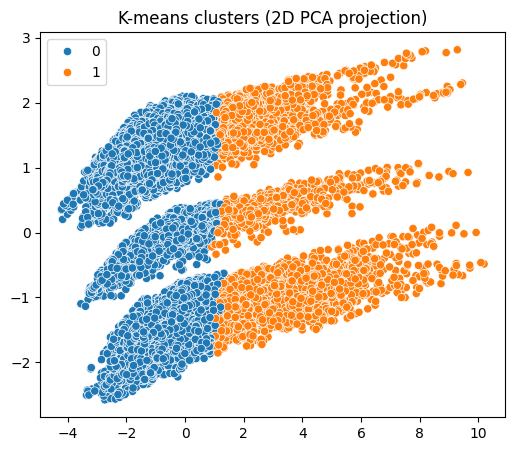

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

df_vis = X_train.copy()
df_vis["power"] = y_train.values
df_vis["cluster"] = train_labels

# Example: cluster means
cluster_summary = df_vis.groupby("cluster").mean().round(3)
display(cluster_summary)

# Quick pairplot or 2D PCA plot
from sklearn.decomposition import PCA
Xp = preprocessor.transform(X_train)
Xp_pca = PCA(n_components=2, random_state=42).fit_transform(Xp)
plt.figure(figsize=(6,5))
sns.scatterplot(x=Xp_pca[:,0], y=Xp_pca[:,1], hue=train_labels, palette="tab10")
plt.title("K-means clusters (2D PCA projection)")
plt.show()

#### Hierarchical agglomerative clustering

In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# optionally still use PCA for stability
USE_PCA_FOR_CLUSTERING = False
PCA_COMPONENTS = 0.95

Xtr_for_cluster = preprocessor.transform(X_train)
if USE_PCA_FOR_CLUSTERING:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    Xtr_for_cluster = pca.fit_transform(Xtr_for_cluster)
else:
    pca = None

In [18]:
k_values = list(range(2, 9))
sil_scores = []
best_k = None
best_score = -np.inf
best_model = None

for k in k_values:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(Xtr_for_cluster)
    s = silhouette_score(Xtr_for_cluster, labels)
    sil_scores.append((k, s))
    if s > best_score:
        best_score = s
        best_k = k
        best_model = model

print("Silhouette scores:", sil_scores)
print(f"Chosen k = {best_k}, score = {best_score:.4f}")

Silhouette scores: [(2, 0.21108426143907486), (3, 0.1460703682248391), (4, 0.13065351444471385), (5, 0.12401769089024796), (6, 0.10073251980959219), (7, 0.09870326136860313), (8, 0.09125618089117386)]
Chosen k = 2, score = 0.2111


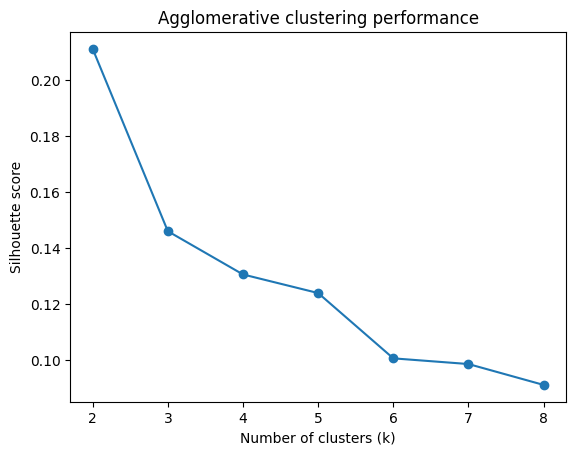

In [19]:
plt.plot([k for k, _ in sil_scores], [s for _, s in sil_scores], marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Agglomerative clustering performance")
plt.show()

In [20]:
def transform_for_cluster(Xdf):
    Xp = preprocessor.transform(Xdf)
    if pca is not None:
        Xp = pca.transform(Xp)
    return Xp

train_labels = best_model.fit_predict(transform_for_cluster(X_train))
val_labels   = best_model.fit_predict(transform_for_cluster(X_val))  # hierarchical has no 'predict'

In [21]:
from sklearn.metrics import pairwise_distances_argmin_min

# compute cluster centroids in feature space
centroids = np.array([
    Xtr_prep[train_labels == cl].mean(axis=0)
    for cl in np.unique(train_labels)
])

# assign validation samples to nearest centroid
val_labels = pairwise_distances_argmin_min(Xval_prep, centroids)[0]

In [22]:
alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models_hier = {}

for cl in np.unique(train_labels):
    idx_train_c = np.where(train_labels == cl)[0]
    Xc, yc = Xtr_prep[idx_train_c], y_train.iloc[idx_train_c]

    idx_val_c = np.where(val_labels == cl)[0]
    Xc_val, yc_val = Xval_prep[idx_val_c], y_val.iloc[idx_val_c]

    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        if len(idx_val_c):
            y_pred_val = m.predict(Xc_val)
            rmse = mean_squared_error(yc_val, y_pred_val)**0.5
        else:
            rmse = np.inf
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    # fallback alpha if cluster not in val
    if best_alpha is None:
        best_alpha = 1.0

    best_model_ridge = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)
    cluster_models_hier[cl] = best_model_ridge

In [23]:
yhat_val = clustered_predict(Xval_prep, val_labels, cluster_models, global_model)
rmse_val = mean_squared_error(y_val, yhat_val)**0.5
mae_val  = mean_absolute_error(y_val, yhat_val)
r2_val   = r2_score(y_val, yhat_val)

print(f"[HIERARCHICAL-VAL] RMSE={rmse_val:.4f}  MAE={mae_val:.4f}  R2={r2_val:.4f}")

[HIERARCHICAL-VAL] RMSE=0.2632  MAE=0.1925  R2=0.7391


In [24]:
models_dict["hierarchical_clustered_ridge"] = {
    "clustering_model": best_model,         # Agglomerative model
    "cluster_models": cluster_models_hier,  # dict of Ridge per cluster
    "preprocessor": preprocessor,
    "centroids": centroids,                 # needed for assigning new samples
    "n_clusters": best_k,
    "notes": "Agglomerative clustering with centroid mapping for val/test"
}

In [25]:
summary_new = pd.DataFrame([
    {"model": "Global Ridge (val)", **global_metrics_val},
    {"model": "Clustered Ridge (KMeans)", **summary.loc[1, ["rmse","mae","r2"]].to_dict()},
    {"model": "Clustered Ridge (Hierarchical)", "rmse": rmse_val, "mae": mae_val, "r2": r2_val},
])
summary_new

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (KMeans),0.263750,0.193130,0.738033
2,Clustered Ridge (Hierarchical),0.263203,0.192473,0.739120


#### hierarchical with temporal continuity

In [26]:
from sklearn.metrics import pairwise_distances

#df = df.sort_values("ts").reset_index(drop=True)
#X, y, _ = get_X_y(df)

# base distance (feature space)
base_dist = pairwise_distances(Xp, metric="euclidean")

# add temporal penalty: large distance for non-adjacent times
n = base_dist.shape[0]
time_penalty = np.ones((n, n)) * 1e6  # big default
for i in range(n):
    if i > 0:
        time_penalty[i, i-1] = 0      # allow neighbor merges
    if i < n-1:
        time_penalty[i, i+1] = 0
temporal_dist = base_dist + time_penalty

In [27]:
k_values = list(range(2, 9))
best_k = None
best_score = -np.inf
best_model = None

for k in k_values:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',
        linkage='average'
    )
    labels = model.fit_predict(temporal_dist)
    s = silhouette_score(Xp, labels)
    print(f"k={k}, silhouette={s:.4f}")
    if s > best_score:
        best_score = s
        best_k = k
        best_model = model

print(f"chosen k = {best_k}, silhouette = {best_score:.4f}")
train_labels = best_model.labels_

k=2, silhouette=0.2006
k=3, silhouette=0.1129
k=4, silhouette=0.0194
k=5, silhouette=0.0156
k=6, silhouette=0.0009
k=7, silhouette=-0.0062
k=8, silhouette=-0.0064
chosen k = 2, silhouette = 0.2006


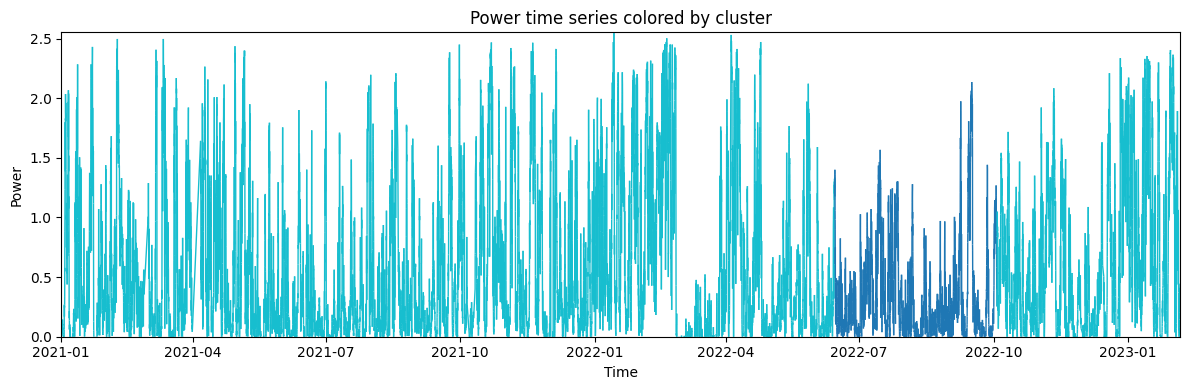

In [29]:
# ensure both are aligned 1-D arrays
ts = df.loc[idx_train, "ts"].to_numpy()
y  = y_train.to_numpy().ravel()
labels = np.asarray(train_labels)

# convert timestamps to matplotlib numbers
ts_num = mdates.date2num(ts)

# build line segments
points = np.column_stack((ts_num, y)).reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# normalize cluster labels
norm = plt.Normalize(labels.min(), labels.max())
lc = LineCollection(segments, cmap='tab10', norm=norm)
lc.set_array(labels)
lc.set_linewidth(1.0)

fig, ax = plt.subplots(figsize=(12,4))
ax.add_collection(lc)
ax.set_xlim(ts_num.min(), ts_num.max())
ax.set_ylim(np.nanmin(y), np.nanmax(y))
ax.xaxis_date()
ax.set_title("Power time series colored by cluster")
ax.set_xlabel("Time")
ax.set_ylabel("Power")
plt.tight_layout()
plt.show()

In [30]:
train_labels = best_model.labels_

alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models_temporal = {}

for cl in np.unique(train_labels):
    idx_train_c = np.where(train_labels == cl)[0]
    Xc, yc = Xtr_prep[idx_train_c], y_train.iloc[idx_train_c]

    # Use the same alpha search strategy
    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        y_pred = m.predict(Xc)
        rmse = mean_squared_error(yc, y_pred)**0.5
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a
    best_model_ridge = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)
    cluster_models_temporal[cl] = best_model_ridge

# Compute cluster centers in feature space
Xp_train = preprocessor.transform(X_train)
centroids = np.array([
    Xp_train[train_labels == cl].mean(axis=0)
    for cl in np.unique(train_labels)
])

# Assign each validation sample to nearest centroid
from sklearn.metrics import pairwise_distances_argmin_min
Xp_val = preprocessor.transform(X_val)
val_labels = pairwise_distances_argmin_min(Xp_val, centroids)[0]

In [31]:
yhat_val = clustered_predict(Xval_prep, val_labels, cluster_models_temporal, global_model)

rmse_val_t = mean_squared_error(y_val, yhat_val)**0.5
mae_val_t  = mean_absolute_error(y_val, yhat_val)
r2_val_t   = r2_score(y_val, yhat_val)

print(f"[TEMPORAL-VAL] RMSE={rmse_val_t:.4f}  MAE={mae_val_t:.4f}  R2={r2_val_t:.4f}")

[TEMPORAL-VAL] RMSE=0.2620  MAE=0.1934  R2=0.7415


In [32]:
models_dict["temporal_clustered_ridge"] = {
    "clustering_model": best_model,
    "cluster_models": cluster_models_temporal,
    "preprocessor": preprocessor,
    "n_clusters": best_k,
    "centroids": centroids,
    "notes": "Hierarchical clustering with temporal continuity constraint (adjacent-only merges)"
}

In [33]:
summary_new = summary_new.copy()
summary_new.loc[len(summary_new)] = {
    "model": "Clustered Ridge (Temporal)",
    "rmse": rmse_val_t,
    "mae": mae_val_t,
    "r2": r2_val_t
}
summary_new

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (KMeans),0.263750,0.193130,0.738033
2,Clustered Ridge (Hierarchical),0.263203,0.192473,0.739120
3,Clustered Ridge (Temporal),0.262018,0.193449,0.741463


#### GMM

In [34]:
# Fit preprocessing (same preprocessor as before)
Xp_train = preprocessor.fit_transform(X_train)
Xp_val   = preprocessor.transform(X_val)

In [35]:
k_values = list(range(2, 9))
bic_scores = []
sil_scores = []

best_k = None
best_model = None
best_score = np.inf

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42
    )
    gmm.fit(Xp_train)
    bic = gmm.bic(Xp_train)
    bic_scores.append((k, bic))
    
    labels = gmm.predict(Xp_train)
    s = silhouette_score(Xp_train, labels)
    sil_scores.append((k, s))
    
    if bic < best_score:
        best_score = bic
        best_k = k
        best_model = gmm

print("BIC scores:", bic_scores)
print("Silhouette scores:", sil_scores)
print(f"Chosen k = {best_k}")

BIC scores: [(2, np.float64(117026.94963831597)), (3, np.float64(110727.70589444204)), (4, np.float64(-67199.14700111902)), (5, np.float64(-60300.03563929477)), (6, np.float64(-259199.27443595347)), (7, np.float64(-323056.41280243266)), (8, np.float64(-301744.2375286593))]
Silhouette scores: [(2, 0.036057138314741354), (3, 0.02539772296312136), (4, 0.09018864523261193), (5, 0.03033087986021272), (6, 0.057069935977850844), (7, 0.06298310702243139), (8, 0.0259464418299786)]
Chosen k = 7


In [36]:
train_labels = best_model.predict(Xp_train)
val_labels   = best_model.predict(Xp_val)

from collections import Counter
print("Train cluster distribution:", Counter(train_labels))

Train cluster distribution: Counter({np.int64(4): 5203, np.int64(0): 3710, np.int64(2): 3278, np.int64(3): 2458, np.int64(5): 1855, np.int64(6): 1345, np.int64(1): 88})


In [37]:
alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models_gmm = {}

for cl in np.unique(train_labels):
    idx_train_c = np.where(train_labels == cl)[0]
    Xc, yc = Xp_train[idx_train_c], y_train.iloc[idx_train_c]

    idx_val_c = np.where(val_labels == cl)[0]
    Xc_val, yc_val = Xp_val[idx_val_c], y_val.iloc[idx_val_c]

    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        if len(idx_val_c):
            rmse = mean_squared_error(yc_val, m.predict(Xc_val))**0.5
        else:
            rmse = np.inf
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    # --- fix: add fallback ---
    if best_alpha is None:
        best_alpha = 1.0  # default if no validation points or equal scores

    best_model_ridge = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)
    cluster_models_gmm[cl] = best_model_ridge

Note: Handling Clusters with No Validation Samples

During per-cluster model training, some clusters may have no validation samples (e.g., len(idx_val_c) == 0).
This happens when:
- The validation split is chronological, so certain regimes (e.g., winter conditions) only appear in the training period.
- Clusters are small or unbalanced, meaning rare regimes vanish in the validation window.
- Random clustering creates partitions that don’t align with time.

How we handle it:
- Keep the chronological split for realism (true forecasting setup).
- Use a default Ridge α = 1.0 for clusters without validation data.
- Note that missing clusters simply represent regimes not observed in the validation period — not an error.

In [38]:
from collections import Counter
print("Train clusters:", Counter(train_labels))
print("Val clusterAs:", Counter(val_labels))

Train clusters: Counter({np.int64(4): 5203, np.int64(0): 3710, np.int64(2): 3278, np.int64(3): 2458, np.int64(5): 1855, np.int64(6): 1345, np.int64(1): 88})
Val clusterAs: Counter({np.int64(4): 1452, np.int64(0): 972, np.int64(2): 971, np.int64(3): 439, np.int64(5): 326, np.int64(6): 255, np.int64(1): 70})


In [39]:
yhat_val = clustered_predict(Xp_val, val_labels, cluster_models_gmm, global_model)

rmse_val_gmm = mean_squared_error(y_val, yhat_val)**0.5
mae_val_gmm  = mean_absolute_error(y_val, yhat_val)
r2_val_gmm   = r2_score(y_val, yhat_val)

print(f"[GMM-VAL] RMSE={rmse_val_gmm:.4f}  MAE={mae_val_gmm:.4f}  R2={r2_val_gmm:.4f}")

[GMM-VAL] RMSE=0.2579  MAE=0.1955  R2=0.7496


In [40]:
models_dict["gmm_clustered_ridge"] = {
    "clustering_model": best_model,         # fitted GaussianMixture model
    "cluster_models": cluster_models_gmm,   # dict of Ridge models per cluster
    "preprocessor": preprocessor,
    "n_clusters": best_k,
    "bic_score": best_score,
    "notes": "GMM clustering with local Ridge regressors; clusters assigned via predict()"
}

In [41]:
summary_gmm = summary_new.copy()  # if you have the previous summary
summary_gmm.loc[len(summary_gmm)] = {
    "model": "Clustered Ridge (GMM)",
    "rmse": rmse_val_gmm,
    "mae": mae_val_gmm,
    "r2": r2_val_gmm
}
summary_gmm

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (KMeans),0.263750,0.193130,0.738033
2,Clustered Ridge (Hierarchical),0.263203,0.192473,0.739120
3,Clustered Ridge (Temporal),0.262018,0.193449,0.741463
4,Clustered Ridge (GMM),0.257885,0.195520,0.749554


#### daily profiles

In [42]:
df

,power,mean_wind_speed_Nex,mean_wind_speed_Hammer_ Odde_Fyr,mean_temp_Hammer_Odde_Fyr,DK2_DKK,ImbalancePriceDKK,BalancingPowerPriceUpDKK,BalancingPowerPriceDownDKK,hour_sin,hour_cos,dow_sin,dow_cos,dayofweek,ts
0,0.133746,2.9,2.3,2.9,358.579987,358.570007,358.570007,358.570007,0.000000,1.000000,-0.433884,-0.900969,4,2021-01-01 00:00:00
1,0.221838,2.5,1.6,2.8,332.459991,332.450012,332.450012,332.450012,0.258819,0.965926,-0.433884,-0.900969,4,2021-01-01 01:00:00
2,0.154125,3.5,1.5,2.5,319.369995,319.350006,319.350006,319.350006,0.500000,0.866025,-0.433884,-0.900969,4,2021-01-01 02:00:00
3,0.127054,2.6,2.2,2.5,300.540009,300.529999,300.529999,300.529999,0.707107,0.707107,-0.433884,-0.900969,4,2021-01-01 03:00:00
4,0.099059,1.4,1.7,2.2,299.130005,299.119995,299.119995,299.119995,0.866025,0.500000,-0.433884,-0.900969,4,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22417,0.000768,0.4,3.0,18.3,975.090027,1899.920044,1899.920044,975.032471,-0.965926,0.258819,0.000000,1.000000,0,2023-08-14 19:00:00
22418,0.000000,1.2,1.9,17.8,827.030029,1199.949951,1199.949951,826.963318,-0.866025,0.500000,0.000000,1.000000,0,2023-08-14 20:00:00
22419,0.066056,1.2,0.0,17.2,753.039978,753.000000,753.000000,753.000000,-0.707107,0.707107,0.000000,1.000000,0,2023-08-14 21:00:00
22420,0.179455,0.7,0.0,17.0,742.219971,1289.859985,1289.859985,742.172424,-0.500000,0.866025,0.000000,1.000000,0,2023-08-14 22:00:00


In [43]:
df = df.sort_values("ts").reset_index(drop=True)
df["date"] = df["ts"].dt.date

profile_features = ["mean_wind_speed_Nex", "mean_temp_Nex", "power"]
profile_features = [f for f in profile_features if f in df.columns]

# group by date and keep only full 24-hour days
complete_days = [
    d for d, g in df.groupby("date")
    if len(g) == 24
]

daily_profiles = (
    df[df["date"].isin(complete_days)]
    .groupby("date")[profile_features]
    .apply(lambda x: x.to_numpy().flatten())
)

# stack into 2D array
X_day = np.vstack(daily_profiles.values)
dates = np.array(daily_profiles.index)

print(f"{len(dates)} complete days, each with shape {X_day.shape[1]} features")

910 complete days, each with shape 48 features


In [44]:
scaler_day = StandardScaler()
X_day_scaled = scaler_day.fit_transform(X_day)

k_values = range(2, 9)
best_score = -np.inf
best_k, best_model = None, None
scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_day_scaled)
    s = silhouette_score(X_day_scaled, labels)
    scores.append((k, s))
    if s > best_score:
        best_score, best_k, best_model = s, k, km

print("Silhouette scores:", scores)
print(f"Chosen k = {best_k}, score = {best_score:.4f}")
day_labels = best_model.predict(X_day_scaled)

Silhouette scores: [(2, 0.4647204721418717), (3, 0.3356908325623776), (4, 0.2551971535275792), (5, 0.20902176983084148), (6, 0.20171187084240433), (7, 0.20661001813987545), (8, 0.19201852716859993)]
Chosen k = 2, score = 0.4647


In [45]:
# map date → cluster
label_map = dict(zip(dates, day_labels))
df["day_cluster"] = df["date"].map(label_map)

# show cluster distribution
df["day_cluster"].value_counts()

day_cluster
1.0    15360
0.0     6480
Name: count, dtype: int64

In [46]:
Xp_train = preprocessor.fit_transform(X_train)
Xp_val   = preprocessor.transform(X_val)

train_labels = df.loc[idx_train, "day_cluster"].to_numpy()
val_labels   = df.loc[idx_val, "day_cluster"].to_numpy()

In [47]:
alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models_daily = {}

for cl in np.unique(train_labels):
    idx_train_c = np.where(train_labels == cl)[0]
    if len(idx_train_c) == 0:
        print(f"⚠️ Skipping cluster {cl} (no training samples)")
        continue

    Xc, yc = Xp_train[idx_train_c], y_train.iloc[idx_train_c]
    idx_val_c = np.where(val_labels == cl)[0]
    Xc_val, yc_val = Xp_val[idx_val_c], y_val.iloc[idx_val_c]

    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        if len(idx_val_c):
            rmse = mean_squared_error(yc_val, m.predict(Xc_val))**0.5
        else:
            rmse = np.inf
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    if best_alpha is None:
        best_alpha = 1.0

    model_best = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)
    cluster_models_daily[cl] = model_best

⚠️ Skipping cluster nan (no training samples)


In [48]:
from collections import Counter
print("Train cluster counts:", Counter(train_labels))
print("Val cluster counts:", Counter(val_labels))

Train cluster counts: Counter({np.float64(1.0): 12207, np.float64(0.0): 5280, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np.float64(nan): 1, np

In [49]:
yhat_val = clustered_predict(Xp_val, val_labels, cluster_models_daily, global_model)

rmse_val_day = mean_squared_error(y_val, yhat_val)**0.5
mae_val_day  = mean_absolute_error(y_val, yhat_val)
r2_val_day   = r2_score(y_val, yhat_val)

print(f"[DAILY-CLUSTERED-VAL] RMSE={rmse_val_day:.4f}  MAE={mae_val_day:.4f}  R2={r2_val_day:.4f}")

[DAILY-CLUSTERED-VAL] RMSE=0.2412  MAE=0.1732  R2=0.7809


In [50]:
models_dict["daily_profile_clustered_ridge"] = {
    "clustering_model": best_model,
    "cluster_models": cluster_models_daily,
    "scaler_day": scaler_day,
    "preprocessor": preprocessor,
    "profile_features": profile_features,
    "n_clusters": best_k,
    "silhouette_score": best_score,
    "label_map": label_map,
    "notes": "K-Means clustering on 24-hour daily profiles with local Ridge regressors"
}

In [51]:
summary_daily = summary_gmm.copy()   # or whichever summary df you’re using
summary_daily.loc[len(summary_daily)] = {
    "model": "Clustered Ridge (Daily Profiles)",
    "rmse": rmse_val_day,
    "mae": mae_val_day,
    "r2": r2_val_day
}
summary_daily

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (KMeans),0.263750,0.193130,0.738033
2,Clustered Ridge (Hierarchical),0.263203,0.192473,0.739120
3,Clustered Ridge (Temporal),0.262018,0.193449,0.741463
4,Clustered Ridge (GMM),0.257885,0.195520,0.749554
5,Clustered Ridge (Daily Profiles),0.241210,0.173165,0.780895


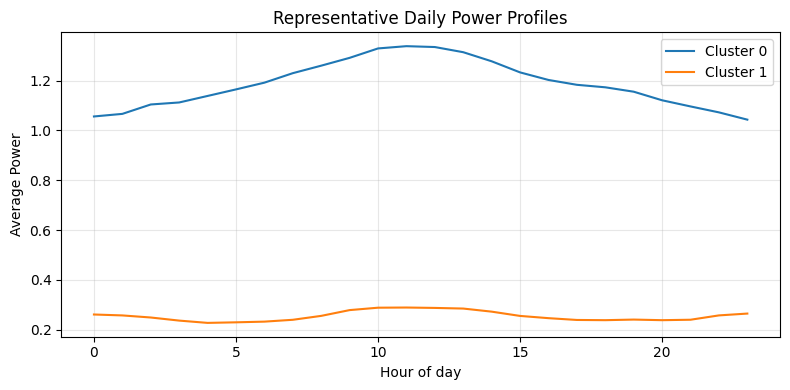

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for cl in np.unique(day_labels):
    days_in_cluster = df[df["day_cluster"] == cl]
    avg_profile = days_in_cluster.groupby(df["ts"].dt.hour)["power"].mean()
    plt.plot(avg_profile.index, avg_profile.values, label=f"Cluster {cl}")

plt.xlabel("Hour of day")
plt.ylabel("Average Power")
plt.title("Representative Daily Power Profiles")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### clustering based on weather conditions

In [53]:
# Choose columns that describe exogenous conditions (adjust patterns as needed)
weather_like = ["wind", "temp", "hum", "prec", "dir"]
season_like  = ["hour_sin","hour_cos","dow_sin","dow_cos"]

def pick_cols(cols, needles):
    needles = [n.lower() for n in needles]
    return [c for c in cols if any(n in c.lower() for n in needles)]

# Robustly obtain column names (X might be a numpy array)
if hasattr(X, "columns"):
    all_cols = X.columns.tolist()
elif 'X_train' in globals() and hasattr(X_train, "columns"):
    all_cols = X_train.columns.tolist()
elif 'feature_names' in globals():
    all_cols = selected_features.copy()
elif 'data' in globals() and hasattr(df, "columns"):
    all_cols = df.columns.tolist()
else:
    raise RuntimeError("Could not determine column names: ensure feature_names, X_train, data or a DataFrame X exists in the notebook scope.")

weather_cols = sorted(set(pick_cols(all_cols, weather_like) + [c for c in season_like if c in all_cols]))
print("Features used for clustering:", weather_cols)

Features used for clustering: ['dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'mean_temp_Hammer_Odde_Fyr', 'mean_wind_speed_Hammer_ Odde_Fyr', 'mean_wind_speed_Nex']


In [54]:
scaler_weather = StandardScaler()
Xtr_weather = scaler_weather.fit_transform(X_train[weather_cols])
Xval_weather = scaler_weather.transform(X_val[weather_cols])

In [55]:
k_values = range(2, 9)
best_k, best_km, best_s = None, None, -np.inf
sil = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    lab = km.fit_predict(Xtr_weather)
    s = silhouette_score(Xtr_weather, lab)
    sil.append((k, s))
    if s > best_s:
        best_s, best_k, best_km = s, k, km

print("Silhouette:", sil)
print("Chosen k:", best_k, "score:", round(best_s, 4))

train_labels = best_km.predict(Xtr_weather)
val_labels   = best_km.predict(Xval_weather)

Silhouette: [(2, 0.1756231803586575), (3, 0.14371963863615517), (4, 0.13429003440627119), (5, 0.14400306578425046), (6, 0.1423880081063898), (7, 0.14190560927808468), (8, 0.14309745967653312)]
Chosen k: 2 score: 0.1756


In [56]:
# Reuse your main preprocessor on the full X (not only weather)
Xtr_full = preprocessor.fit_transform(X_train)
Xval_full = preprocessor.transform(X_val)

alphas = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]
cluster_models_weather = {}

for cl in np.unique(train_labels):
    idx_tr = np.where(train_labels == cl)[0]
    if len(idx_tr) == 0:
        continue  # safety

    Xc, yc = Xtr_full[idx_tr], y_train.iloc[idx_tr]

    idx_va = np.where(val_labels == cl)[0]
    Xc_val, yc_val = Xval_full[idx_va], y_val.iloc[idx_va]

    best_alpha, best_rmse = None, np.inf
    for a in alphas:
        m = Ridge(alpha=a, random_state=42).fit(Xc, yc)
        rmse = np.sqrt(mean_squared_error(yc_val, m.predict(Xc_val))) if len(idx_va) else np.inf
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    if best_alpha is None:
        best_alpha = 1.0
    cluster_models_weather[cl] = Ridge(alpha=best_alpha, random_state=42).fit(Xc, yc)

In [57]:
def clustered_predict(Xp, labels, models, fallback_model):
    import numpy as np
    yhat = np.zeros(Xp.shape[0])
    for cl, model in models.items():
        idx = np.where(labels == cl)[0]
        if len(idx): yhat[idx] = model.predict(Xp[idx])
    missing = np.where([l not in models for l in labels])[0]
    if len(missing): yhat[missing] = fallback_model.predict(Xp[missing])
    return yhat

yhat_val = clustered_predict(Xval_full, val_labels, cluster_models_weather, global_model)
rmse_w = np.sqrt(mean_squared_error(y_val, yhat_val))
mae_w  = mean_absolute_error(y_val, yhat_val)
r2_w   = r2_score(y_val, yhat_val)
print(f"[Weather-Only Clustered (val)] RMSE={rmse_w:.4f}  MAE={mae_w:.4f}  R2={r2_w:.4f}")

[Weather-Only Clustered (val)] RMSE=0.2566  MAE=0.1792  R2=0.7521


In [58]:
models_dict["weather_only_clustered_ridge"] = {
    "clustering_model": best_km,
    "cluster_models": cluster_models_weather,
    "preprocessor": preprocessor,
    "scaler_weather": scaler_weather,
    "weather_cols": weather_cols,
    "n_clusters": best_k,
    "silhouette_score": best_s,
    "notes": "K-Means clustering on weather and seasonal features with local Ridge regressors"
}

### 4. Comparison of All Models

In [59]:
summary_weather = summary_daily.copy()  # or your latest results df
summary_weather.loc[len(summary_weather)] = {
    "model": "Clustered Ridge (Weather-only clustering)",
    "rmse": rmse_w, "mae": mae_w, "r2": r2_w
}
summary_weather

,model,rmse,mae,r2
0,Global Ridge (val),0.262079,0.194137,0.741343
1,Clustered Ridge (KMeans),0.263750,0.193130,0.738033
2,Clustered Ridge (Hierarchical),0.263203,0.192473,0.739120
3,Clustered Ridge (Temporal),0.262018,0.193449,0.741463
4,Clustered Ridge (GMM),0.257885,0.195520,0.749554
5,Clustered Ridge (Daily Profiles),0.241210,0.173165,0.780895
6,Clustered Ridge (Weather-only clustering),0.256555,0.179203,0.752130


### 5. Test Set Evaluation 

In [60]:
models_dict

{'global_ridge': {'model': Ridge(random_state=42),
  'preprocessor': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())]),
  'n_clusters': 1},
 'kmeans_clustered_ridge': {'clustering_model': KMeans(n_clusters=2, random_state=42),
  'cluster_models': {np.int32(0): Ridge(alpha=30.0, random_state=42),
   np.int32(1): Ridge(alpha=30.0, random_state=42)},
  'preprocessor': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())]),
  'n_clusters': 2,
  'scaler': None,
  'notes': 'hourly k-means clustering with Ridge regressors'},
 'hierarchical_clustered_ridge': {'clustering_model': AgglomerativeClustering(),
  'cluster_models': {np.int64(0): Ridge(alpha=30.0, random_state=42),
   np.int64(1): Ridge(alpha=30.0, random_state=42)},
  'preprocessor': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())]),
  'centroids': array([

In [61]:
# --- load the test dataset ---
test_df = pd.read_csv("data/final_data_test.csv")
test_df["ts"] = pd.to_datetime(test_df["ts"])
#test_df = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns], errors="ignore")
test_df = test_df[selected_features + ["ts"]]

# --- extract features and target ---
X_test, y_test, _ = get_X_y(test_df)

# --- storage for results ---
results_test = []
#feature_cols = [f for f in selected_features if f != "power"]
X_test = pd.DataFrame(X_test, columns=feature_cols)

# --- evaluate each trained model stored in models_dict ---
for key, entry in models_dict.items():
    print(f"\n=== Evaluating {key} ===")

    # skip pure metadata entries if any
    if "model" in key and "clustered" not in key:
        continue

    preproc = entry.get("preprocessor")
    global_model = models_dict["global_ridge"]["model"]
    # transform only the feature columns that were used during training to avoid
    # "feature names should match" errors
    Xte_prep = preproc.transform(X_test[feature_cols])

    # --- GLOBAL RIDGE ---
    if key == "global_ridge":
        yhat = entry["model"].predict(Xte_prep)
        mse = mean_squared_error(y_test, yhat)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test, yhat)
        r2   = r2_score(y_test, yhat)
        n_clusters = entry.get("n_clusters", "-")
        results_test.append([key, n_clusters, rmse, mae, r2])
        print(f"RMSE={rmse:.4f}  MAE={mae:.4f}  R²={r2:.4f}  n_clusters={n_clusters}")
        continue

    # --- K-MEANS-BASED ---
    if "kmeans" in key:
        km = entry["clustering_model"]
        test_labels = km.predict(Xte_prep)
        yhat = clustered_predict(Xte_prep, test_labels, entry["cluster_models"], global_model)

    # --- HIERARCHICAL or TEMPORAL (centroid mapping) ---
    elif "hierarchical" in key or "temporal" in key:
        centroids = entry["centroids"]
        test_labels = pairwise_distances_argmin_min(Xte_prep, centroids)[0]
        yhat = clustered_predict(Xte_prep, test_labels, entry["cluster_models"], global_model)

    # --- GMM ---
    elif "gmm" in key:
        gmm = entry["clustering_model"]
        test_labels = gmm.predict(Xte_prep)
        yhat = clustered_predict(Xte_prep, test_labels, entry["cluster_models"], global_model)

    # --- DAILY PROFILE ---
    elif "daily_profile" in key:
        day_kmeans = entry["clustering_model"]
        scaler_day = entry["scaler_day"]
        features = entry["profile_features"]

        test_df["date"] = test_df["ts"].dt.date
        complete_days = [d for d, g in test_df.groupby("date") if len(g) == 24]
        daily_profiles_test = (
            test_df[test_df["date"].isin(complete_days)]
            .groupby("date")[features]
            .apply(lambda x: x.to_numpy().flatten())
        )
        if len(daily_profiles_test) == 0:
            print("⚠️ No complete days in test set — skipping daily-profile evaluation.")
            continue
        X_day_test = np.vstack(daily_profiles_test.values)
        X_day_scaled_test = scaler_day.transform(X_day_test)
        day_labels_test = day_kmeans.predict(X_day_scaled_test)
        day_label_map_test = dict(zip(complete_days, day_labels_test))
        test_df["day_cluster"] = test_df["date"].map(day_label_map_test)
        test_labels = test_df["day_cluster"].to_numpy()
        yhat = clustered_predict(Xte_prep, test_labels, entry["cluster_models"], global_model)

    # --- WEATHER-ONLY ---
    elif "weather_only" in key:
        scaler_weather = entry["scaler_weather"]
        weather_cols = entry["weather_cols"]
        Xte_weather = scaler_weather.transform(X_test[weather_cols])
        clusterer = entry["clustering_model"]
        test_labels = clusterer.predict(Xte_weather)
        yhat = clustered_predict(Xte_prep, test_labels, entry["cluster_models"], global_model)

    # --- fallback if no cluster type matched ---
    else:
        print(f"Skipping unknown entry: {key}")
        continue

    # --- compute metrics ---
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, yhat)
    r2   = r2_score(y_test, yhat)
    
    # fetch cluster count if available
    n_clusters = entry.get("n_clusters", "-")

    results_test.append([key, n_clusters, rmse, mae, r2])
    print(f"RMSE={rmse:.4f}  MAE={mae:.4f}  R²={r2:.4f}")

# --- results summary table ---
results_test_df = pd.DataFrame(results_test, columns=["Model", "N_Clusters", "RMSE", "MAE", "R²"])


=== Evaluating global_ridge ===
RMSE=0.4718  MAE=0.3507  R²=-0.1956  n_clusters=1

=== Evaluating kmeans_clustered_ridge ===
RMSE=0.4825  MAE=0.3556  R²=-0.2504

=== Evaluating hierarchical_clustered_ridge ===
RMSE=0.4825  MAE=0.3555  R²=-0.2505

=== Evaluating temporal_clustered_ridge ===
RMSE=0.4775  MAE=0.3539  R²=-0.2247

=== Evaluating gmm_clustered_ridge ===
RMSE=0.4711  MAE=0.3508  R²=-0.1920

=== Evaluating daily_profile_clustered_ridge ===
RMSE=0.4544  MAE=0.3098  R²=-0.1089

=== Evaluating weather_only_clustered_ridge ===
RMSE=0.4951  MAE=0.3446  R²=-0.3164


In [62]:
summary_val = summary_weather.rename(
    columns={
        "model": "Model",
        "rmse": "RMSE (val)",
        "mae": "MAE (val)",
        "r2": "R² (val)"
    }
)
results_test = results_test_df.rename(
    columns={
        "RMSE": "RMSE (test)",
        "MAE": "MAE (test)",
        "R²": "R² (test)"
    }
)

name_map = {
    "Global Ridge (val)": "global_ridge",
    "Clustered Ridge (KMeans)": "kmeans_clustered_ridge",
    "Clustered Ridge (Hierarchical)": "hierarchical_clustered_ridge",
    "Clustered Ridge (Temporal)": "temporal_clustered_ridge",
    "Clustered Ridge (GMM)": "gmm_clustered_ridge",
    "Clustered Ridge (Daily Profiles)": "daily_profile_clustered_ridge",
    "Clustered Ridge (Weather-only clustering)": "weather_only_clustered_ridge"
}

summary_val["Model"] = summary_val["Model"].map(name_map)

combined = pd.merge(
    summary_val,
    results_test,
    on="Model",
    how="outer"
)

def get_cluster_count(entry):
    if "n_clusters" in entry:
        return entry["n_clusters"]
    elif "n_components" in entry:
        return entry["n_components"]
    elif "clustering_model" in entry and hasattr(entry["clustering_model"], "n_clusters"):
        return entry["clustering_model"].n_clusters
    elif "cluster_models" in entry:
        return len(entry["cluster_models"])
    else:
        return 1  # global ridge fallback

combined["Clusters (k)"] = combined["Model"].apply(
    lambda m: get_cluster_count(models_dict.get(m, {}))
)

cols = [
    "Model", "Clusters (k)",
    "RMSE (val)", "RMSE (test)",
    "MAE (val)", "MAE (test)",
    "R² (val)", "R² (test)"
]
combined = combined[cols]

combined = combined.sort_values("RMSE (test)").reset_index(drop=True)
display(combined.round(4))

,Model,Clusters (k),RMSE (val),RMSE (test),MAE (val),MAE (test),R² (val),R² (test)
0,daily_profile_clustered_ridge,2,0.2412,0.4544,0.1732,0.3098,0.7809,-0.1089
1,gmm_clustered_ridge,7,0.2579,0.4711,0.1955,0.3508,0.7496,-0.1920
2,global_ridge,1,0.2621,0.4718,0.1941,0.3507,0.7413,-0.1956
3,temporal_clustered_ridge,2,0.2620,0.4775,0.1934,0.3539,0.7415,-0.2247
4,kmeans_clustered_ridge,2,0.2638,0.4825,0.1931,0.3556,0.7380,-0.2504
5,hierarchical_clustered_ridge,2,0.2632,0.4825,0.1925,0.3555,0.7391,-0.2505
6,weather_only_clustered_ridge,2,0.2566,0.4951,0.1792,0.3446,0.7521,-0.3164
